<a id='1'></a>
# Import packages

In [1]:
from keras.layers import *
import keras.backend as K
import tensorflow as tf

/home/bryan/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from umeyama import umeyama
from image_augmentation import random_transform
from prefetch_generator import background # !pip install prefetch_generator

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import cv2
import glob
import time
import numpy as np
from scipy import ndimage
from pathlib import PurePath, Path
from random import randint, shuffle
from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

<a id='4'></a>
# Config

In [4]:
K.set_learning_phase(1)
# K.set_learning_phase(0) # set to 0 in inference phase (video conversion)

In [5]:
# Input/Output resolution
RESOLUTION = 64 # 64x64, 128x128, 256x256
assert (RESOLUTION % 64) == 0, "RESOLUTION should be 64, 128, or 256."

# Batch size
batchSize = 8

# Use motion blurs (data augmentation)
# set True if training data contains images extracted from videos
use_da_motion_blur = False 

# Probability of random color matching (data augmentation)
prob_random_color_match = 0.5

# Path to training images
img_dirA = './faceA'
img_dirB = './faceB'
img_dirA_bm_eyes = "./binary_masks/faceA_eyes"
img_dirB_bm_eyes = "./binary_masks/faceB_eyes"

# Path to saved model weights
models_dir = "./models"

In [6]:
# Architecture configuration
arch_config = {}
arch_config['IMAGE_SHAPE'] = (RESOLUTION, RESOLUTION, 3)
arch_config['use_self_attn'] = True
arch_config['norm'] = "instancenorm" # instancenorm, batchnorm, layernorm, groupnorm, none
arch_config['model_capacity'] = "standard" # standard, lite

In [7]:
# Loss function weights configuration
loss_weights = {}
loss_weights['w_D'] = 0.1 # Discriminator
loss_weights['w_recon'] = 1. # L1 reconstruction loss
loss_weights['w_edge'] = 0.1 # edge loss
loss_weights['w_eyes'] = 30. # reconstruction and edge loss on eyes area
loss_weights['w_pl'] = (0.01, 0.1, 0.3, 0.1) # perceptual loss (0.003, 0.03, 0.3, 0.3)

# Init. loss config.
loss_config = {}
loss_config["gan_training"] = "mixup_LSGAN" # "mixup_LSGAN" or "relativistic_avg_LSGAN"
loss_config['use_PL'] = False
loss_config['use_mask_hinge_loss'] = False
loss_config['m_mask'] = 0.
loss_config['lr_factor'] = 1.
loss_config['use_cyclic_loss'] = False

<a id='5'></a>
# Define models

In [8]:
from networks.faceswap_gan_model import FaceswapGANModel

In [9]:
model = FaceswapGANModel(**arch_config)

<a id='6'></a>
# Load Model Weights

Weights file names:
```python
encoder.h5, decoder_A.h5, deocder_B.h5, netDA.h5, netDB.h5
```

In [10]:
model.load_weights(path=models_dir)

Model weights files are successfully loaded.


### (The following cells are for training, jump to [transform_face()](#tf) or [video conversion](#vc) for inference.)

# Define Losses and Build Training Functions

TODO: split into two methods

In [11]:
# https://github.com/rcmalli/keras-vggface
#!pip install keras_vggface
from keras_vggface.vggface import VGGFace

# VGGFace ResNet50
vggface = VGGFace(include_top=False, model='resnet50', input_shape=(224, 224, 3))

#vggface.summary()

model.build_pl_model(vggface_model=vggface)

In [12]:
model.build_train_functions(loss_weights=loss_weights, **loss_config)

<a id='9'></a>
# DataLoader

TODO: write a DataLoader class

In [13]:
# Motion blurs as data augmentation
def get_motion_blur_kernel(sz=7):
    rot_angle = np.random.uniform(-180,180)
    kernel = np.zeros((sz,sz))
    kernel[int((sz-1)//2), :] = np.ones(sz)
    kernel = ndimage.interpolation.rotate(kernel, rot_angle, reshape=False)
    kernel = np.clip(kernel, 0, 1)
    normalize_factor = 1 / np.sum(kernel)
    kernel = kernel * normalize_factor
    return kernel

def motion_blur(images, sz=7):
    # images is a list [image2, image2, ...]
    blur_sz = np.random.choice([5, 7, 9, 11])
    kernel_motion_blur = get_motion_blur_kernel(blur_sz)
    for i, image in enumerate(images):
        images[i] = cv2.filter2D(image, -1, kernel_motion_blur).astype(np.float64)
    return images

In [14]:
# Utils for loading data
def load_data(file_pattern):
    return glob.glob(file_pattern)
  
def random_warp_rev(image, res=RESOLUTION):
    assert image.shape == (256,256,6)
    res_scale = res//64
    assert res_scale >= 1, "Resolution should be >= 64. Recieved {res}.".format(res=res)
    interp_param = 80 * res_scale
    interp_slice = slice(interp_param//10,9*interp_param//10)
    dst_pnts_slice = slice(0,65*res_scale,16*res_scale)
    
    rand_coverage = np.random.randint(20) + 80 # random warping coverage
    rand_scale = np.random.uniform(5., 6.2) # random warping scale
    
    range_ = np.linspace(128-rand_coverage, 128+rand_coverage, 5)
    mapx = np.broadcast_to(range_, (5,5))
    mapy = mapx.T
    mapx = mapx + np.random.normal(size=(5,5), scale=rand_scale)
    mapy = mapy + np.random.normal(size=(5,5), scale=rand_scale)
    interp_mapx = cv2.resize(mapx, (interp_param,interp_param))[interp_slice,interp_slice].astype('float32')
    interp_mapy = cv2.resize(mapy, (interp_param,interp_param))[interp_slice,interp_slice].astype('float32')
    warped_image = cv2.remap(image, interp_mapx, interp_mapy, cv2.INTER_LINEAR)
    src_points = np.stack([mapx.ravel(), mapy.ravel()], axis=-1)
    dst_points = np.mgrid[dst_pnts_slice,dst_pnts_slice].T.reshape(-1,2)
    mat = umeyama(src_points, dst_points, True)[0:2]
    target_image = cv2.warpAffine(image, mat, (res,res))
    return warped_image, target_image

def random_color_match(image):
    global fns_all_trn_data
    rand_idx = np.random.randint(len(fns_all_trn_data))
    fn_match = fns_all_trn_data[rand_idx]
    tar_img = cv2.imread(fn_match)
    if tar_img is None:
        print("Failed reading image {fn_match} in random_color_match().".format(fn_match=fn_match))
        return image
    r = 60
    src_img = cv2.resize(image, (256,256))
    tar_img = cv2.resize(tar_img, (256,256))
    mt = np.mean(tar_img[r:-r,r:-r,:], axis=(0,1))
    st = np.std(tar_img[r:-r,r:-r,:], axis=(0,1))
    ms = np.mean(src_img[r:-r,r:-r,:], axis=(0,1))
    ss = np.std(src_img[r:-r,r:-r,:], axis=(0,1))    
    if ss.any() <= 1e-7: return src_img    
    result = st * (src_img.astype(np.float32) - ms) / (ss+1e-7) + mt
    if result.min() < 0:
        result = result - result.min()
    if result.max() > 255:
        result = (255.0/result.max()*result).astype(np.float32)
    return result

random_transform_args = {
    'rotation_range': 10,
    'zoom_range': 0.1,
    'shift_range': 0.05,
    'random_flip': 0.5,
    }
def read_image(fn, dir_bm_eyes=None, random_transform_args=random_transform_args):
    assert dir_bm_eyes is not None
    raw_fn = PurePath(fn).parts[-1]
    image = cv2.imread(fn)
    assert image is not None, "Failed reading image {fn}.".format(fn=fn)
    image = cv2.resize(image, (256,256)) / 255 * 2 - 1
    bm_eyes = cv2.imread("{dir_bm_eyes}/{raw_fn}".format(dir_bm_eyes=dir_bm_eyes, raw_fn=raw_fn))
    assert bm_eyes is not None, "Failed reading binary mask {dir_bm_eyes}/{raw_fn}.".format(dir_bm_eyes=dir_bm_eyes, raw_fn=raw_fn)
    bm_eyes = cv2.resize(bm_eyes, (256,256)) / 255.
    image = np.concatenate([image, bm_eyes], axis=-1)
    image = random_transform(image, **random_transform_args)
    warped_img, target_img = random_warp_rev(image)
    
    bm_eyes = target_img[...,3:]
    warped_img = warped_img[...,:3]
    target_img = target_img[...,:3]
    
    # Motion blur data augmentation:
    # we want the model to learn to preserve motion blurs of input images
    if np.random.uniform() < 0.25 and use_da_motion_blur: 
        warped_img, target_img = motion_blur([warped_img, target_img])
    
    return warped_img, target_img, bm_eyes

In [15]:
# A generator function that yields epoch and data
@background(32)
def minibatch(data, batchsize, dir_bm_eyes):
    length = len(data)
    epoch = i = 0
    tmpsize = None  
    shuffle(data)
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(data)
            i = 0
            epoch+=1        
        rtn = np.float32([read_image(data[j], dir_bm_eyes) for j in range(i,i+size)])
        i+=size
        tmpsize = yield epoch, rtn[:,0,:,:,:], rtn[:,1,:,:,:], rtn[:,2,:,:,:]       

def create_minibatch(data, batchsize, dir_bm_eyes):
    # This is a redundant function, to be written in to a DataLoader class.
    batch = minibatch(data, batchsize, dir_bm_eyes)
    tmpsize = None    
    while True:        
        ep1, warped_img, target_img, bm_eyes = next(batch)
        tmpsize = yield ep1, warped_img, target_img, bm_eyes

# Visualizer

TODO: write a Visualizer class

In [16]:
from utils import showG, showG_mask, showG_eyes

<a id='10'></a>
# Start Training
TODO: make training script compact

In [17]:
# Create ./models directory
Path("models").mkdir(parents=True, exist_ok=True)

In [18]:
# Get filenames
train_A = load_data(img_dirA+"/*.*")
train_B = load_data(img_dirB+"/*.*")

global fns_all_trn_data
fns_all_trn_data = train_A + train_B

assert len(train_A), "No image found in " + str(img_dirA)
assert len(train_B), "No image found in " + str(img_dirB)
print ("Number of images in folder A: " + str(len(train_A)))
print ("Number of images in folder B: " + str(len(train_B)))

assert len(glob.glob(img_dirA_bm_eyes+"/*.*")), "No binary mask found in " + str(img_dirA_bm_eyes)
assert len(glob.glob(img_dirB_bm_eyes+"/*.*")), "No binary mask found in " + str(img_dirB_bm_eyes)
assert len(glob.glob(img_dirA_bm_eyes+"/*.*")) == len(train_A), \
"Number of faceA images does not match number of their binary masks. Can be caused by any none image file in the folder."
assert len(glob.glob(img_dirB_bm_eyes+"/*.*")) == len(train_B), \
"Number of faceB images does not match number of their binary masks. Can be caused by any none image file in the folder."

Number of images in folder A: 365
Number of images in folder B: 307


In [19]:
def show_loss_config(loss_config):
    for config, value in loss_config.items():
        print("{config} = {value}".format(config=config, value=value))

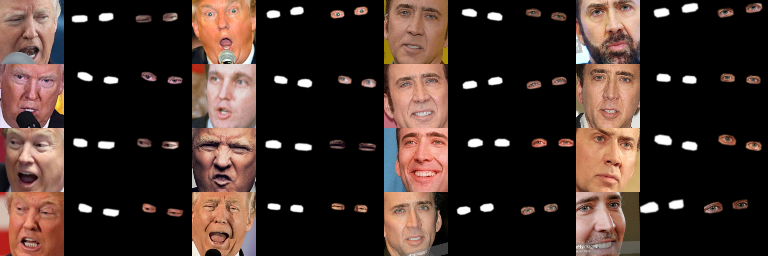

In [20]:
# Display random binary masks of eyes
train_batchA = create_minibatch(train_A, batchSize, img_dirA_bm_eyes)
train_batchB = create_minibatch(train_B, batchSize, img_dirB_bm_eyes)
_, _, tA, bmA = next(train_batchA)  
_, _, tB, bmB = next(train_batchB)
showG_eyes(tA, tB, bmA, bmB, batchSize)

In [21]:
def reset_session(save_path):
    global model, vggface
    model.save_weights(path=save_path)
    del model
    del vggface
    K.clear_session()
    model = FaceswapGANModel(**arch_config)
    model.load_weights(path=save_path)
    vggface = VGGFace(include_top=False, model='resnet50', input_shape=(224, 224, 3))
    model.build_pl_model(vggface_model=vggface)

m_mask = 0.0
use_PL = True
use_mask_hinge_loss = False
gan_training = mixup_LSGAN
lr_factor = 0.1
use_cyclic_loss = False
----------
[iter 39900] Loss_DA: 0.057928 Loss_DB: 0.074258 Loss_GA: 0.886672 Loss_GB: 0.973593 time: 16464.453028
----------
Generator loss details:
[Adversarial loss]
GA: 0.1322 GB: 0.1335
[Reconstruction loss]
GA: 0.2343 GB: 0.2559
[Edge loss]
GA: 0.2354 GB: 0.3254
[Perceptual loss]
GA: 0.2100 GB: 0.1852
----------
Transformed (masked) results:


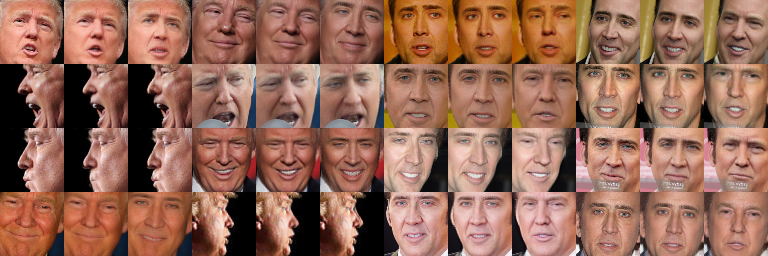

Masks:


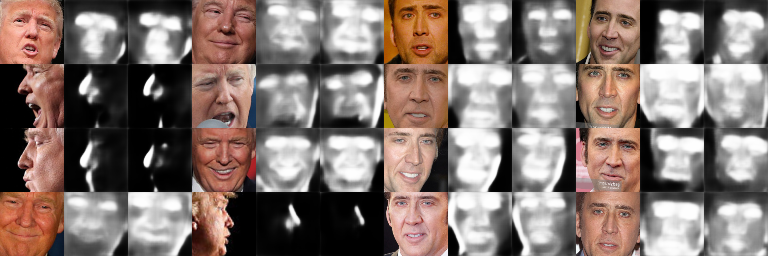

Reconstruction results:


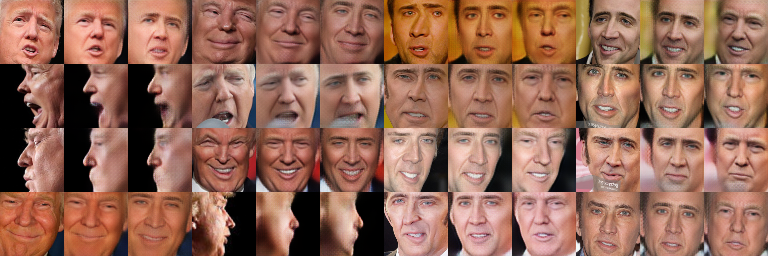

Model weights files have been saved to ./models.
Model weights files have been saved to ./models/backup_iter40000.


In [22]:
# Start training
t0 = time.time()
gen_iterations = 0
errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0
errGAs = {}
errGBs = {}
# Dictionaries are ordered in Python 3.6
for k in ['ttl', 'adv', 'recon', 'edge', 'pl']:
    errGAs[k] = 0
    errGBs[k] = 0

display_iters = 300
backup_iters = 5000
TOTAL_ITERS = 40000

train_batchA = create_minibatch(train_A, batchSize, img_dirA_bm_eyes)
train_batchB = create_minibatch(train_B, batchSize, img_dirB_bm_eyes)

while gen_iterations <= TOTAL_ITERS:  
    data_A = next(train_batchA) 
    data_B = next(train_batchB) 
    
    # Loss function automation
    if gen_iterations == (TOTAL_ITERS//5 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = False
        loss_config['m_mask'] = 0.0
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    elif gen_iterations == (TOTAL_ITERS//5 + TOTAL_ITERS//10 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = True
        loss_config['m_mask'] = 0.5
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Complete.")
    elif gen_iterations == (2*TOTAL_ITERS//5 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = True
        loss_config['m_mask'] = 0.2
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    elif gen_iterations == (TOTAL_ITERS//2 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = True
        loss_config['m_mask'] = 0.4
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    elif gen_iterations == (2*TOTAL_ITERS//3 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = False
        loss_config['m_mask'] = 0.
        loss_config['lr_factor'] = 0.3
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    elif gen_iterations == (8*TOTAL_ITERS//10 - display_iters//2):
        clear_output()
        model.decoder_A.load_weights("models/decoder_B.h5") # swap decoders
        model.decoder_B.load_weights("models/decoder_A.h5") # swap decoders
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = True
        loss_config['m_mask'] = 0.1
        loss_config['lr_factor'] = 0.3
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    elif gen_iterations == (9*TOTAL_ITERS//10 - display_iters//2):
        clear_output()
        loss_config['use_PL'] = True
        loss_config['use_mask_hinge_loss'] = False
        loss_config['m_mask'] = 0.0
        loss_config['lr_factor'] = 0.1
        reset_session(models_dir)
        print("Building new loss funcitons...")
        show_loss_config(loss_config)
        model.build_train_functions(loss_weights=loss_weights, **loss_config)
        print("Done.")
    
    if gen_iterations == 5:
        print ("working.")
    
    # Train dicriminators for one batch
    errDA, errDB = model.train_one_batch_D(data_A=data_A, data_B=data_B)
    errDA_sum += errDA[0]
    errDB_sum += errDB[0]

    # Train generators for one batch
    errGA, errGB = model.train_one_batch_G(data_A=data_A, data_B=data_B)
    errGA_sum += errGA[0]
    errGB_sum += errGB[0]
    for i, k in enumerate(['ttl', 'adv', 'recon', 'edge', 'pl']):
        errGAs[k] += errGA[i]
        errGBs[k] += errGB[i]
    gen_iterations+=1
    
    # Visualization
    if gen_iterations % display_iters == 0:
        clear_output()
            
        # Display loss information
        show_loss_config(loss_config)
        print("----------") 
        print('[iter %d] Loss_DA: %f Loss_DB: %f Loss_GA: %f Loss_GB: %f time: %f'
        % (gen_iterations, errDA_sum/display_iters, errDB_sum/display_iters,
           errGA_sum/display_iters, errGB_sum/display_iters, time.time()-t0))  
        print("----------") 
        print("Generator loss details:")
        print('[Adversarial loss]')  
        print('GA: {:.4f} GB: {:.4f}'.format(errGAs["adv"]/display_iters, errGBs["adv"]/display_iters))
        print('[Reconstruction loss]')
        print('GA: {:.4f} GB: {:.4f}'.format(errGAs["recon"]/display_iters, errGBs["recon"]/display_iters))
        print('[Edge loss]')
        print('GA: {:.4f} GB: {:.4f}'.format(errGAs["edge"]/display_iters, errGBs["edge"]/display_iters))
        if loss_config['use_PL'] == True:
            print('[Perceptual loss]')
            try:
                print('GA: {:.4f} GB: {:.4f}'.format(errGAs["pl"][0]/display_iters, errGBs["pl"][0]/display_iters))
            except:
                print('GA: {:.4f} GB: {:.4f}'.format(errGAs["pl"]/display_iters, errGBs["pl"]/display_iters))
        
        # Display images
        print("----------") 
        _, wA, tA, _ = next(train_batchA)  
        _, wB, tB, _ = next(train_batchB)
        print("Transformed (masked) results:")
        showG(tA, tB, model.path_A, model.path_B, batchSize)   
        print("Masks:")
        showG_mask(tA, tB, model.path_mask_A, model.path_mask_B, batchSize)  
        print("Reconstruction results:")
        showG(wA, wB, model.path_bgr_A, model.path_bgr_B, batchSize)           
        errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0
        for k in ['ttl', 'adv', 'recon', 'edge', 'pl']:
            errGAs[k] = 0
            errGBs[k] = 0
        
        # Save models
        model.save_weights(path=models_dir)
    
    # Backup models
    if gen_iterations % backup_iters == 0: 
        bkup_dir = "{models_dir}/backup_iter{gen_iterations}".format(models_dir=models_dir, gen_iterations=gen_iterations)
        Path(bkup_dir).mkdir(parents=True, exist_ok=True)
        model.save_weights(path=bkup_dir)

# Further train the model adding cycle consistency loss (optional)

In [124]:
loss_config = {}
loss_config['use_PL'] = True
loss_config['use_mask_hinge_loss'] = False
loss_config['m_mask'] = 0.
loss_config['lr_factor'] = 0.1
loss_config['use_cyclic_loss'] = True
model.build_train_functions(loss_weights=loss_weights, **loss_config)

KeyError: 'gan_training'

In [125]:
t0 = time.time()
gen_iterations = 0
epoch = 0
errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0

display_iters = 300
batchSize = batchSize//2
train_batchA = create_minibatch(train_A, batchSize)
train_batchB = create_minibatch(train_B, batchSize)

# ========== Change TOTAL_ITERS to desired iterations  ========== 
TOTAL_ITERS = 10000

while gen_iterations <= TOTAL_ITERS:  
    data_A = next(train_batchA) 
    data_B = next(train_batchB)
   
    # Train dicriminators for one batch
    if gen_iterations % 1 == 0:
        errDA, errDB = model.train_one_batch_D(data_A=data_A, data_B=data_B)
    errDA_sum +=errDA[0]
    errDB_sum +=errDB[0]

    if gen_iterations == 5:
        print ("working.")

    # Train generators for one batch
    errGA, errGB = model.train_one_batch_G(data_A=data_A, data_B=data_B)
    errGA_sum += errGA[0]
    errGB_sum += errGB[0]
    gen_iterations+=1

    if gen_iterations % display_iters == 0:
        if gen_iterations % (display_iters) == 0:
            clear_output()
        show_loss_config(loss_config)
        print('[iter %d] Loss_DA: %f Loss_DB: %f Loss_GA: %f Loss_GB: %f time: %f'
        % (gen_iterations, errDA_sum/display_iters, errDB_sum/display_iters,
          errGA_sum/display_iters, errGB_sum/display_iters, time.time()-t0))   

        # get new batch of images and generate results for visualization
        for _ in range(1):           
            print("----------") 
            _, wA, tA, _ = next(train_batchA)  
            _, wB, tB, _ = next(train_batchB)
            showG(tA, tB, model.path_A, model.path_B)   
            print("")
            showG(wA, wB, model.path_bgr_A, model.path_bgr_B)  
            print("")
            showG_mask(tA, tB, model.path_mask_A, model.path_mask_B)           
        errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0

        # Save models (save with latest weights)
        model.encoder.save_weights("models/encoder.h5")
        model.decoder_A.save_weights("models/decoder_A.h5")
        model.decoder_B.save_weights("models/decoder_B.h5")
        model.netDA.save_weights("models/netDA.h5")
        model.netDB.save_weights("models/netDB.h5")

TypeError: create_minibatch() missing 1 required positional argument: 'dir_bm_eyes'

<a id='tf'></a>
# Helper Function for Single Image Transformation: transform_face()

    INPUTS:
        inp_img: A RGB face image of any size.
        path_func: a function that is either path_abgr_A or path_abgr_B.
        roi_coef: A coefficient that affects the cropped center area
        color_correction: boolean, whether use color correction or not
    OUPUTS:
        result_img: A RGB swapped face image after masking.
        result_mask: The alpha mask image which correspons to the result_img.

In [86]:
def shift_n_scale(src_img, tar_img):
    mt = np.mean(tar_img, axis=(0,1))
    st = np.std(tar_img, axis=(0,1))
    ms = np.mean(src_img, axis=(0,1))
    ss = np.std(src_img, axis=(0,1))    
    if ss.any() <= 1e-7: return src_img    
    result = st * (src_img.astype(np.float32) - ms) / (ss+1e-7) + mt
    result = (255.0/result.max()*result).astype(np.float32)
    return result

def transform_face(inp_img, direction="AtoB", roi_coef=15, color_correction=False):
    def get_feather_edges_mask(img, roi_coef):
        img_size = img.shape
        mask = np.zeros_like(img)
        mask[img_size[0]//roi_coef:-img_size[0]//roi_coef, 
             img_size[1]//roi_coef:-img_size[1]//roi_coef,:]  = 255
        mask = cv2.GaussianBlur(mask,(15,15),10)
        return mask        

    if direction == "AtoB":
        path_func = model.path_abgr_B
    elif direction == "BtoA":
        path_func = model.path_abgr_A
    else:
        raise ValueError("direction should be either AtoB or BtoA, recieved {direction}.".format(direction=direction))

    # pre-process input image
    img_bgr = cv2.cvtColor(inp_img, cv2.COLOR_RGB2BGR)
    input_size = img_bgr.shape        
    roi = img_bgr[input_size[0]//roi_coef:-input_size[0]//roi_coef, 
                  input_size[1]//roi_coef:-input_size[1]//roi_coef,:] # BGR, [0, 255]  
    roi_size = roi.shape
    ae_input = cv2.resize(roi, (RESOLUTION,RESOLUTION))/255. * 2 - 1 # BGR, [-1, 1]       

    # post-process transformed roi image
    ae_output = np.squeeze(np.array([path_func([[ae_input]])]))
    ae_output_a = ae_output[:,:,0] * 255
    ae_output_a = cv2.resize(ae_output_a, (roi_size[1],roi_size[0]))[...,np.newaxis]
    ae_output_bgr = np.clip( (ae_output[:,:,1:] + 1) * 255 / 2, 0, 255)
    ae_output_bgr = cv2.resize(ae_output_bgr, (roi_size[1],roi_size[0]))
    ae_output_masked = (ae_output_a/255 * ae_output_bgr + (1 - ae_output_a/255) * roi).astype('uint8') # BGR, [0, 255]
    if color_correction:
        ae_output_masked = shift_n_scale(ae_output_masked, roi)

    # merge transformed output back to input image
    blend_mask = get_feather_edges_mask(roi, roi_coef)        
    blended_img = blend_mask/255 * ae_output_masked + (1-blend_mask/255) * roi
    result = img_bgr
    result[input_size[0]//roi_coef:-input_size[0]//roi_coef, \
           input_size[1]//roi_coef:-input_size[1]//roi_coef,:] = blended_img 
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB) 
    result_alpha = np.zeros_like(img_bgr)
    result_alpha[input_size[0]//roi_coef:-input_size[0]//roi_coef, \
                 input_size[1]//roi_coef:-input_size[1]//roi_coef,:] = (blend_mask/255) * ae_output_a 
    return result, result_alpha

In [120]:
input_img = plt.imread("./TEST_IMAGE.jpg")

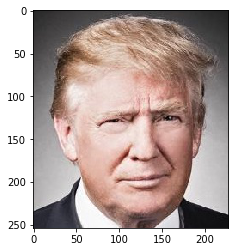

In [121]:
plt.imshow(input_img)

In [122]:
result_img, result_mask = transform_face(input_img, direction="AtoB", roi_coef=15)

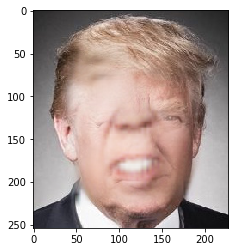

In [123]:
plt.imshow(result_img)

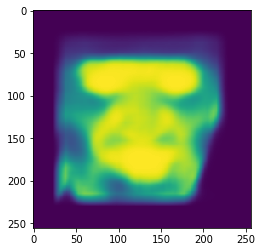

In [119]:
plt.imshow(result_mask[..., 0])

<a id='vc'></a>
# Video Conversion

TODO: write another script for inference and video conversion

### Note: Code for video conversion is loosely organized and not well maintained.

In [31]:
# Download ffmpeg if needed, which is required by moviepy.

#import imageio
#imageio.plugins.ffmpeg.download()

In [32]:
#!pip install moviepy

In [33]:
from moviepy.editor import VideoFileClip
import mtcnn_detect_face
import os

ImportError: No module named 'moviepy'

### Build MTCNN for face detection

In [ ]:
def create_mtcnn(sess, model_path):
    if not model_path:
        model_path,_ = os.path.split(os.path.realpath(__file__))

    with tf.variable_scope('pnet2'):
        data = tf.placeholder(tf.float32, (None,None,None,3), 'input')
        pnet = mtcnn_detect_face.PNet({'data':data})
        pnet.load(os.path.join(model_path, 'det1.npy'), sess)
    with tf.variable_scope('rnet2'):
        data = tf.placeholder(tf.float32, (None,24,24,3), 'input')
        rnet = mtcnn_detect_face.RNet({'data':data})
        rnet.load(os.path.join(model_path, 'det2.npy'), sess)
    with tf.variable_scope('onet2'):
        data = tf.placeholder(tf.float32, (None,48,48,3), 'input')
        onet = mtcnn_detect_face.ONet({'data':data})
        onet.load(os.path.join(model_path, 'det3.npy'), sess)
    return pnet, rnet, onet

In [ ]:
WEIGHTS_PATH = "./mtcnn_weights/"

sess = K.get_session()
with sess.as_default():
    global pnet, rnet, onet 
    pnet2, rnet2, onet2 = create_mtcnn(sess, WEIGHTS_PATH)

global pnet, rnet, onet
pnet_fun = K.function([pnet2.layers['data']],[pnet2.layers['conv4-2'], pnet2.layers['prob1']])
rnet_fun = K.function([rnet2.layers['data']],[rnet2.layers['conv5-2'], rnet2.layers['prob1']])
onet_fun = K.function([onet2.layers['data']], [onet2.layers['conv6-2'], onet2.layers['conv6-3'], onet2.layers['prob1']])

with tf.variable_scope('pnet2', reuse=True):
    data = tf.placeholder(tf.float32, (None,None,None,3), 'input')
    pnet2 = mtcnn_detect_face.PNet({'data':data})
    pnet2.load(os.path.join("./mtcnn_weights/", 'det1.npy'), sess)
with tf.variable_scope('rnet2', reuse=True):
    data = tf.placeholder(tf.float32, (None,24,24,3), 'input')
    rnet2 = mtcnn_detect_face.RNet({'data':data})
    rnet2.load(os.path.join("./mtcnn_weights/", 'det2.npy'), sess)
with tf.variable_scope('onet2', reuse=True):
    data = tf.placeholder(tf.float32, (None,48,48,3), 'input')
    onet2 = mtcnn_detect_face.ONet({'data':data})
    onet2.load(os.path.join("./mtcnn_weights/", 'det3.npy'), sess)
    
pnet = K.function([pnet2.layers['data']],[pnet2.layers['conv4-2'], pnet2.layers['prob1']])
rnet = K.function([rnet2.layers['data']],[rnet2.layers['conv5-2'], rnet2.layers['prob1']])
onet = K.function([onet2.layers['data']], [onet2.layers['conv6-2'], onet2.layers['conv6-3'], onet2.layers['prob1']])

### Utils for video conversion

In [ ]:
use_smoothed_mask = True
use_smoothed_bbox = True

def get_src_landmarks(x0, x1, y0, y1, pnts):
    """
    x0, x1, y0, y1: (smoothed) bbox coord.
    pnts: landmarks predicted by MTCNN
    """    
    src_landmarks = []
    for i in range(5):
        src_landmarks.extend([(int(pnts[i+5][0]-x0), int(pnts[i][0]-y0))])
    return src_landmarks

def get_tar_landmarks(img):
    """    
    img: detected face image
    """         
    avg_landmarks = [
        (0.31339227236234224, 0.3259269274198092),
        (0.31075140146108776, 0.7228453709528997),
        (0.5523683107816256, 0.5187296867370605),
        (0.7752419985257663, 0.37262483743520886),
        (0.7759613623985877, 0.6772957581740159)
        ]   
    
    tar_landmarks = []
    img_size = img.shape
    for xy in avg_landmarks: 
        tar_landmarks.extend([(int(xy[0]*img_size[0]), int(xy[1]*img_size[1]))])
    return tar_landmarks

def landmarks_match_mtcnn(src_im, src_landmarks, tar_landmarks):  
    # umeyama(src, dst, estimate_scale)
    # landmarks coord. should be (width, height) or (y, x)
    src_size = src_im.shape
    src_tmp = []
    dst_tmp = []
    for xy in src_landmarks:
        src_tmp.extend([(int(xy[1]), int(xy[0]))])
    for xy in tar_landmarks:
        dst_tmp.extend([(int(xy[1]), int(xy[0]))])
    M = umeyama(np.array(src_tmp), np.array(dst_tmp), True)[0:2]
    result = cv2.warpAffine(src_im, M, (src_size[1], src_size[0]), borderMode=cv2.BORDER_REPLICATE) 
    return result

def shift_n_scale(src_img, tar_img):
    # https://github.com/ftokarev/tf-adain/blob/master/adain/norm.py
    mt = np.mean(tar_img, axis=(0,1))
    st = np.std(tar_img, axis=(0,1))
    ms = np.mean(src_img, axis=(0,1))
    ss = np.std(src_img, axis=(0,1))    
    if ss.any() <= 1e-7: return src_img    
    result = st * (src_img.astype(np.float32) - ms) / (ss+1e-7) + mt
    result = (255.0/result.max()*result).astype(np.float32)
    return result

def transform_face_video_conv(model, inp_img, direction="A2B", roi_coef=15, color_correction=False):
    def get_feather_edges_mask(img, roi_coef):
        img_size = img.shape
        mask = np.zeros_like(img)
        mask[img_size[0]//roi_coef:-img_size[0]//roi_coef, 
             img_size[1]//roi_coef:-img_size[1]//roi_coef,:]  = 255
        mask = cv2.GaussianBlur(mask,(15,15),10)
        return mask        

    if direction == "AtoB":
        path_func = model.path_abgr_B
    elif direction == "BtoA":
        path_func = model.path_abgr_A
    else:
        raise ValueError(f"direction should be either AtoB or BtoA, recieved {direction}.")

    # pre-process input image
    img_bgr = cv2.cvtColor(inp_img, cv2.COLOR_RGB2BGR)
    input_size = img_bgr.shape        
    roi = img_bgr[input_size[0]//roi_coef:-input_size[0]//roi_coef, 
                  input_size[1]//roi_coef:-input_size[1]//roi_coef,:] # BGR, [0, 255]  
    roi_size = roi.shape
    ae_input = cv2.resize(roi, model.IMAGE_SHAPE[:2])/255. * 2 - 1 # BGR, [-1, 1]       

    # post-process transformed roi image
    ae_output = np.squeeze(np.array([path_func([[ae_input]])]))
    ae_output_a = ae_output[:,:,0] * 255
    ae_output_a = cv2.resize(ae_output_a, (roi_size[1],roi_size[0]))[...,np.newaxis]
    ae_output_bgr = np.clip( (ae_output[:,:,1:] + 1) * 255 / 2, 0, 255)
    ae_output_bgr = cv2.resize(ae_output_bgr, (roi_size[1],roi_size[0]))
    ae_output_masked = (ae_output_a/255 * ae_output_bgr + (1 - ae_output_a/255) * roi).astype('uint8') # BGR, [0, 255]
    if color_correction == "adain":
        ae_output_masked = shift_n_scale(ae_output_masked, roi)
        ae_output_bgr = shift_n_scale(ae_output_bgr, roi)
    elif color_correction == "hist_match":
        ae_output_masked = color_hist_match(ae_output_masked, roi)
        ae_output_bgr = color_hist_match(ae_output_bgr, roi)

    # merge transformed output back to input image
    blend_mask = get_feather_edges_mask(roi, roi_coef)        
    blended_img = blend_mask/255 * ae_output_masked + (1-blend_mask/255) * roi
    result = img_bgr.copy()
    result[input_size[0]//roi_coef:-input_size[0]//roi_coef, \
           input_size[1]//roi_coef:-input_size[1]//roi_coef,:] = blended_img 
    result_rawRGB = img_bgr.copy()
    result_rawRGB[input_size[0]//roi_coef:-input_size[0]//roi_coef, \
                  input_size[1]//roi_coef:-input_size[1]//roi_coef,:] = ae_output_bgr 
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB) 
    result_rawRGB = cv2.cvtColor(result_rawRGB, cv2.COLOR_BGR2RGB)
    result_alpha = np.zeros_like(img_bgr)
    result_alpha[input_size[0]//roi_coef:-input_size[0]//roi_coef, \
                 input_size[1]//roi_coef:-input_size[1]//roi_coef,:] = (blend_mask/255) * ae_output_a 
    return result, result_rawRGB, result_alpha

def is_overlap(box1, box2):
    overlap_x0 = np.max([box1[0], box2[0]]).astype(np.float32)
    overlap_y1 = np.min([box1[1], box2[1]]).astype(np.float32)
    overlap_x1 = np.min([box1[2], box2[2]]).astype(np.float32)
    overlap_y0 = np.max([box1[3], box2[3]]).astype(np.float32)
    area_iou = (overlap_x1-overlap_x0) * (overlap_y1-overlap_y0)
    area_box1 = (box1[2]-box1[0]) * (box1[1]-box1[3])
    area_box2 = (box2[2]-box2[0]) * (box2[1]-box2[3])    
    return (area_iou / area_box1) >= 0.2
    
def remove_overlaps(faces):    
    main_face = get_most_conf_face(faces)
    main_face_bbox = main_face[0]
    result_faces = []
    result_faces.append(main_face_bbox)
    for (x0, y1, x1, y0, conf_score) in faces:
        if not is_overlap(main_face_bbox, (x0, y1, x1, y0)):
            result_faces.append((x0, y1, x1, y0, conf_score))
    return result_faces

def get_most_conf_face(faces):
    # Return the bbox w/ the highest confidence score
    best_conf_score = 0
    conf_face = None
    for (x0, y1, x1, y0, conf_score) in faces: 
        if conf_score >= best_conf_score:
            best_conf_score = conf_score
            conf_face = [(x0, y1, x1, y0, conf_score)]
    return conf_face

def kalmanfilter_init(noise_coef):
    kf = cv2.KalmanFilter(4,2)
    kf.measurementMatrix = np.array([[1,0,0,0],[0,1,0,0]], np.float32)
    kf.transitionMatrix = np.array([[1,0,1,0],[0,1,0,1],[0,0,1,0],[0,0,0,1]], np.float32)
    kf.processNoiseCov = noise_coef * np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]], np.float32)
    return kf

def is_higher_than_480p(x):
    return (x.shape[0] * x.shape[1]) >= (858*480)

def is_higher_than_720p(x):
    return (x.shape[0] * x.shape[1]) >= (1280*720)

def is_higher_than_1080p(x):
    return (x.shape[0] * x.shape[1]) >= (1920*1080)

def calibrate_coord(faces, video_scaling_factor):
    for i, (x0, y1, x1, y0, _) in enumerate(faces):
        faces[i] = (x0*video_scaling_factor, y1*video_scaling_factor, 
                    x1*video_scaling_factor, y0*video_scaling_factor, _)
    return faces

def calibrate_landmarks(pnts, video_scaling_factor):
    for i, xy in enumerate(pnts):
        pnts[i] = xy*video_scaling_factor
    return pnts

def process_mtcnn_bbox(bboxes, im_shape):
    # output bbox coordinate of MTCNN is (y0, x0, y1, x1)
    # Here we process the bbox coord. to a square bbox with ordering (x0, y1, x1, y0)
    for i, bbox in enumerate(bboxes):
        y0, x0, y1, x1 = bboxes[i,0:4]
        w = int(y1 - y0)
        h = int(x1 - x0)
        length = (w + h)/2
        center = (int((x1+x0)/2),int((y1+y0)/2))
        new_x0 = np.max([0, (center[0]-length//2)])#.astype(np.int32)
        new_x1 = np.min([im_shape[0], (center[0]+length//2)])#.astype(np.int32)
        new_y0 = np.max([0, (center[1]-length//2)])#.astype(np.int32)
        new_y1 = np.min([im_shape[1], (center[1]+length//2)])#.astype(np.int32)
        bboxes[i,0:4] = new_x0, new_y1, new_x1, new_y0
    return bboxes

def get_faces_bbox(image):  
    global pnet, rnet, onet 
    global detec_threshold
    minsize = 20 # minimum size of face
    threshold = [ 0.6, 0.7, detec_threshold ]  # three steps's threshold
    factor = 0.709 # scale factor
    if manually_downscale:
        video_scaling_factor = manually_downscale_factor
        resized_image = cv2.resize(image, 
                                   (image.shape[1]//video_scaling_factor, 
                                    image.shape[0]//video_scaling_factor))
        faces, pnts = mtcnn_detect_face.detect_face(resized_image, minsize, pnet, rnet, onet, threshold, factor)
        faces = process_mtcnn_bbox(faces, resized_image.shape)
        faces = calibrate_coord(faces, video_scaling_factor)
        pnts = calibrate_landmarks(pnts, video_scaling_factor)
    elif is_higher_than_1080p(image):
        video_scaling_factor = 4 + video_scaling_offset
        resized_image = cv2.resize(image, 
                                   (image.shape[1]//video_scaling_factor, 
                                    image.shape[0]//video_scaling_factor))
        faces, pnts = mtcnn_detect_face.detect_face(resized_image, minsize, pnet, rnet, onet, threshold, factor)
        faces = process_mtcnn_bbox(faces, resized_image.shape)
        faces = calibrate_coord(faces, video_scaling_factor)
        pnts = calibrate_landmarks(pnts, video_scaling_factor)
    elif is_higher_than_720p(image):
        video_scaling_factor = 3 + video_scaling_offset
        resized_image = cv2.resize(image, 
                                   (image.shape[1]//video_scaling_factor, 
                                    image.shape[0]//video_scaling_factor))
        faces, pnts = mtcnn_detect_face.detect_face(resized_image, minsize, pnet, rnet, onet, threshold, factor)
        faces = process_mtcnn_bbox(faces, resized_image.shape)
        faces = calibrate_coord(faces, video_scaling_factor)  
        pnts = calibrate_landmarks(pnts, video_scaling_factor)
    elif is_higher_than_480p(image):
        video_scaling_factor = 2 + video_scaling_offset
        resized_image = cv2.resize(image, 
                                   (image.shape[1]//video_scaling_factor, 
                                    image.shape[0]//video_scaling_factor))
        faces, pnts = mtcnn_detect_face.detect_face(resized_image, minsize, pnet, rnet, onet, threshold, factor)
        faces = process_mtcnn_bbox(faces, resized_image.shape)
        faces = calibrate_coord(faces, video_scaling_factor)
        pnts = calibrate_landmarks(pnts, video_scaling_factor)
    else:
        faces, pnts = mtcnn_detect_face.detect_face(image, minsize, pnet, rnet, onet, threshold, factor)
        faces = process_mtcnn_bbox(faces, image.shape)
    return faces, pnts

def get_smoothed_coord(x0, x1, y0, y1, shape, ratio=0.65):
    global prev_x0, prev_x1, prev_y0, prev_y1
    if not use_kalman_filter:
        x0 = int(ratio * prev_x0 + (1-ratio) * x0)
        x1 = int(ratio * prev_x1 + (1-ratio) * x1)
        y1 = int(ratio * prev_y1 + (1-ratio) * y1)
        y0 = int(ratio * prev_y0 + (1-ratio) * y0)
    else:
        x0y0 = np.array([x0, y0]).astype(np.float32)
        x1y1 = np.array([x1, y1]).astype(np.float32)
        kf0.correct(x0y0)
        pred_x0y0 = kf0.predict()
        kf1.correct(x1y1)
        pred_x1y1 = kf1.predict()
        x0 = np.max([0, pred_x0y0[0][0]]).astype(np.int)
        x1 = np.min([shape[0], pred_x1y1[0][0]]).astype(np.int)
        y0 = np.max([0, pred_x0y0[1][0]]).astype(np.int)
        y1 = np.min([shape[1], pred_x1y1[1][0]]).astype(np.int)
        if x0 == x1 or y0 == y1:
            x0, y0, x1, y1 = prev_x0, prev_y0, prev_x1, prev_y1
    return x0, x1, y0, y1     
    
def set_global_coord(x0, x1, y0, y1):
    global prev_x0, prev_x1, prev_y0, prev_y1
    prev_x0 = x0
    prev_x1 = x1
    prev_y1 = y1
    prev_y0 = y0
"""    
def generate_face(ae_input, path_abgr, roi_size, roi_image):
    result = np.squeeze(np.array([path_abgr([[ae_input]])]))
    result_a = result[:,:,0] * 255
    result_a = cv2.GaussianBlur(result_a, (7,7), 6)
    result_a = cv2.resize(result_a, (roi_size[1],roi_size[0]))[...,np.newaxis]
    result_bgr = np.clip((result[:,:,1:] + 1) * 255 / 2, 0, 255)
    result_bgr = cv2.resize(result_bgr, (roi_size[1],roi_size[0]))
    result = (result_a/255 * result_bgr + (1 - result_a/255) * roi_image).astype(np.uint8)
    result = cv2.cvtColor(result.astype(np.uint8), cv2.COLOR_BGR2RGB)
    if use_color_correction:
        result = adain(result, roi_image)
    return result.astype(np.uint8), result_a.astype(np.uint8)
"""
def get_init_mask_map(image):
    return np.zeros_like(image)

def get_init_comb_img(input_img):
    comb_img = np.zeros([input_img.shape[0], input_img.shape[1]*2,input_img.shape[2]])
    comb_img[:, :input_img.shape[1], :] = input_img
    comb_img[:, input_img.shape[1]:, :] = input_img
    return comb_img    

def get_init_triple_img(input_img, no_face=False):
    if no_face:
        triple_img = np.zeros([input_img.shape[0], input_img.shape[1]*3,input_img.shape[2]])
        triple_img[:, :input_img.shape[1], :] = input_img
        triple_img[:, input_img.shape[1]:input_img.shape[1]*2, :] = input_img      
        triple_img[:, input_img.shape[1]*2:, :] = (input_img * .15).astype('uint8')  
        return triple_img
    else:
        triple_img = np.zeros([input_img.shape[0], input_img.shape[1]*3,input_img.shape[2]])
        return triple_img

def get_mask(roi_image, h, w):
    mask = np.zeros_like(roi_image)
    mask[h//15:-h//15,w//15:-w//15,:] = 255
    mask = cv2.GaussianBlur(mask,(15,15),10)
    return mask

""" Color corretion functions"""
def hist_match(source, template):
    # Code borrow from:
    # https://stackoverflow.com/questions/32655686/histogram-matching-of-two-images-in-python-2-x
    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

def color_hist_match(src_im, tar_im):
    #src_im = cv2.cvtColor(src_im, cv2.COLOR_BGR2Lab)
    #tar_im = cv2.cvtColor(tar_im, cv2.COLOR_BGR2Lab)
    matched_R = hist_match(src_im[:,:,0], tar_im[:,:,0])
    matched_G = hist_match(src_im[:,:,1], tar_im[:,:,1])
    matched_B = hist_match(src_im[:,:,2], tar_im[:,:,2])
    matched = np.stack((matched_R, matched_G, matched_B), axis=2).astype(np.float64)
    return matched

def adain(src_im, tar_im):
    # https://github.com/ftokarev/tf-adain/blob/master/adain/norm.py
    mt = np.mean(tar_im, axis=(0,1))
    st = np.std(tar_im, axis=(0,1))
    ms = np.mean(src_im, axis=(0,1))
    ss = np.std(src_im, axis=(0,1))    
    if ss.any() <= 1e-7: return src_im    
    result = st * (src_im.astype(np.float32) - ms) / (ss+1e-7) + mt
    result = (255.0/result.max()*result).astype(np.float32)
    return result

def process_video(input_img): 
    global prev_x0, prev_x1, prev_y0, prev_y1
    global frames      
    global pnet, rnet, onet
    global roi_coef
    global direction
    """
    # The following if statement is meant to solve a bug that has an unknow cause.
    # (No such bug using tensorflow-cpu)
    if frames <= -1:
        with tf.variable_scope('pnet2', reuse=True):
            pnet2 = None
            data = tf.placeholder(tf.float32, (None,None,None,3), 'input')
            pnet2 = mtcnn_detect_face.PNet({'data':data})
            pnet2.load(os.path.join("./mtcnn_weights/", 'det1.npy'), sess)
        with tf.variable_scope('rnet2', reuse=True):
            rnet2 = None
            data = tf.placeholder(tf.float32, (None,24,24,3), 'input')
            rnet2 = mtcnn_detect_face.RNet({'data':data})
            rnet2.load(os.path.join("./mtcnn_weights/", 'det2.npy'), sess)
        with tf.variable_scope('onet2', reuse=True):
            onet2 = None
            data = tf.placeholder(tf.float32, (None,48,48,3), 'input')
            onet2 = mtcnn_detect_face.ONet({'data':data})
            onet2.load(os.path.join("./mtcnn_weights/", 'det3.npy'), sess)
        pnet = K.function([pnet2.layers['data']],
                          [pnet2.layers['conv4-2'], 
                           pnet2.layers['prob1']])
        rnet = K.function([rnet2.layers['data']],
                          [rnet2.layers['conv5-2'], 
                           rnet2.layers['prob1']])
        onet = K.function([onet2.layers['data']], 
                          [onet2.layers['conv6-2'], 
                           onet2.layers['conv6-3'], 
                           onet2.layers['prob1']])
    """
    
    image = input_img
    
    # detect face using MTCNN
    # faces: face bbox coord, pnts: landmarks coord.
    faces, pnts = get_faces_bbox(image)
    
    # check if any face detected
    if len(faces) == 0:
        comb_img = get_init_comb_img(input_img)
        triple_img = get_init_triple_img(input_img, no_face=True)
    else:
        faces = remove_overlaps(faces) # Has non-max suppress already been implemented in MTCNN?
    
    # init. output image
    mask_map = get_init_mask_map(image)
    comb_img = get_init_comb_img(input_img)
    best_conf_score = 0
    
    # loop through all detected faces
    for (x0, y1, x1, y0, conf_score) in faces:    
        # smoothe the bounding box
        if use_smoothed_bbox:
            if frames != 0 and conf_score >= best_conf_score:
                x0, x1, y0, y1 = get_smoothed_coord(x0, x1, y0, y1, 
                                                    image.shape, 
                                                    ratio=0.65 if use_kalman_filter else bbox_moving_avg_coef)
                set_global_coord(x0, x1, y0, y1)
                best_conf_score = conf_score
                frames += 1
            elif conf_score <= best_conf_score:
                frames += 1
            else:
                if conf_score >= best_conf_score:
                    set_global_coord(x0, x1, y0, y1)
                    best_conf_score = conf_score
                if use_kalman_filter:
                    for i in range(200):
                        kf0.predict()
                        kf1.predict()
                frames += 1
        
        # transform face
        try:
            # get detected face
            det_face_im = input_img[int(x0):int(x1),int(y0):int(y1),:]

            # get src/tar landmarks
            src_landmarks = get_src_landmarks(x0, x1, y0, y1, pnts)
            tar_landmarks = get_tar_landmarks(det_face_im)

            # align detected face
            aligned_det_face_im = landmarks_match_mtcnn(det_face_im, src_landmarks, tar_landmarks)

            # face transform
            r_im, r_rgb, r_a = transform_face_video_conv(
                model,
                aligned_det_face_im, 
                direction=direction, 
                roi_coef=roi_coef,
                color_correction=use_color_correction
                )

            # reverse alignment
            rev_aligned_det_face_im = landmarks_match_mtcnn(r_rgb, tar_landmarks, src_landmarks)
            rev_aligned_mask = landmarks_match_mtcnn(r_a, tar_landmarks, src_landmarks)

            # merge source face and transformed face
            result = np.zeros_like(det_face_im)
            result = rev_aligned_mask/255*rev_aligned_det_face_im + (1-rev_aligned_mask/255)*det_face_im
            result_a = rev_aligned_mask
        except:            
            # catch exceptions for landmarks alignment errors (if any)
            print(f"Face alignment error occurs at frame {frames}.")
            result, _, result_a = transform_face_video_conv(
                model,
                input_img[int(x0):int(x1),int(y0):int(y1),:],
                direction=direction, 
                roi_coef=roi_coef,
                color_correction=use_color_correction
                )
        
        comb_img[int(x0):int(x1),input_img.shape[1]+int(y0):input_img.shape[1]+int(y1),:] = result
        
        if conf_score >= best_conf_score:
            mask_map[int(x0):int(x1),int(y0):int(y1),:] = result_a
            mask_map = np.clip(mask_map + .15 * input_img, 0, 255)     
        else:
            mask_map[int(x0):int(x1),int(y0):int(y1),:] += result_a
            mask_map = np.clip(mask_map, 0, 255)
            
        triple_img = get_init_triple_img(input_img)
        triple_img[:, :input_img.shape[1]*2, :] = comb_img
        triple_img[:, input_img.shape[1]*2:, :] = mask_map
        
        # Draw bbox
        #cv2.rectangle(triple_img,(int(y0),int(x0)),(int(y1),int(x1)),(0,255,125),3
        
    global output_type
    if output_type == 1:
        return comb_img[:, input_img.shape[1]:, :]  # return only result image
    elif output_type == 2:
        return comb_img  # return input and result image combined as one
    elif output_type == 3:
        return triple_img #return input,result and mask heatmap image combined as one

### Video conversion configuration

In [ ]:
use_kalman_filter = True
if use_kalman_filter:
    noise_coef = 5e-3 # Increase by 10x if tracking is slow. 
    kf0 = kalmanfilter_init(noise_coef)
    kf1 = kalmanfilter_init(noise_coef)
else:
    bbox_moving_avg_coef = 0.65
    
video_scaling_offset = 0 # Increase by 1 if OOM happens.
manually_downscale = False
manually_downscale_factor = int(2) # should be an positive integer
use_color_correction = "adain" # none, adain, hist_match

# Output type: 
#    1. [ result ] 
#    2. [ source | result ] 
#    3. [ source | result | mask ]
global output_type
output_type = 3

# Detection threshold:  a float point between 0 and 1. Decrease this value if faces are missed.
global detec_threshold
detec_threshold = 0.7

# Center area of input images to be cropped into
# Suggest value: 5 ~ 25
global roi_coef
roi_coef = 15

### Set transform direction

In [ ]:
global direction
direction = "AtoB" # default trainsforming faceA to faceB

### Start video conversion

In [ ]:
# Variables for smoothing bounding box
global prev_x0, prev_x1, prev_y0, prev_y1
global frames
global prev_pnts1, prev_pnts2
prev_x0 = prev_x1 = prev_y0 = prev_y1 = 0
frames = 0
prev_pnts1 = prev_pnts2 = np.array([])

output = 'OUTPUT_VIDEO.mp4'
clip1 = VideoFileClip("INPUT_VIDEO.mp4")
clip = clip1.fl_image(process_video)#.subclip(7.5, 9) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)
clip1.reader.close()
try:
    clip1.audio.reader.close_proc()
except:
    pass